# Feature Engineering

En el presente Notebook se continuará con los datos limpios generados en la etapa anterior, y se prepararán para utilizarlos en el modelo de Machine Learning. También se elijirá cual es el modelo adecuado para nuestro caso de análisis.

La etapa de análisis de datos y visualización se puede encontrar en el Notebook [*02 Eduardo_Nunez_Analisis_Datos.ipynb*](https://github.com/EduGatoX/datascience02/blob/main/02%20Eduardo_Nunez_Analisis_Datos.ipynb) alojado en GitHub.

### Importación de librerias

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Carga de datos limpios

Los datos alojados en [*videogame_data_clean.csv*](https://github.com/EduGatoX/datascience02/blob/main/videogame_data_clean.csv) ya han sido previamente limpiados, es decir, se imputaron nulos y se eliminaron outliers en la etapa anterior.

In [165]:
df = pd.read_csv("videogame_data_clean.csv")

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12332 entries, 0 to 12331
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   12332 non-null  int64  
 1   Name         12332 non-null  object 
 2   Franchise    12332 non-null  object 
 3   Platform     12332 non-null  object 
 4   Year         12332 non-null  float64
 5   Genre        12332 non-null  object 
 6   Publisher    12332 non-null  object 
 7   NA_Sales     12332 non-null  float64
 8   EU_Sales     12332 non-null  float64
 9   JP_Sales     12332 non-null  float64
 10  Other_Sales  12332 non-null  float64
 11  playtime     12332 non-null  float64
 12  metacritic   12332 non-null  float64
 13  rating       12332 non-null  float64
 14  exceptional  12332 non-null  float64
 15  recommended  12332 non-null  float64
 16  meh          12332 non-null  float64
 17  skip         12332 non-null  float64
 18  esrb_rating  12332 non-null  object 
dtypes: f

### Eliminación de variables

Se eliminan las columnas:

- **Unnamed: 0**: Esta columna se elimina porque proviene del guardado anterior en donde no se indicó a la función que la primera columna era index.
- **Name**: Se eliminará la variable *Name* ya que nos interesa evaluar el desempeño de los videojuegos desde un punto de vista general y no idiosincrático a un juego en particular.

In [167]:
df = df.drop(columns=["Unnamed: 0", "Name"])

### Transformación de variables

Se desea evaluar un modelo para la variable target **Global_Sales**. De esta forma, las variables *NA_Sales*, *EU_Sales*, *JP_Sales* y *Other_Sales* parecen redudantes ya que **Global_Sales** es la suma de las anteriores. Sin embargo, se procede a transformar estas variables a variables porcentuales respecto de **Global Sales** de forma de que representen la distribución de ventas en esas localidades.

In [168]:
# Se recupera la variable de interes "Global_Sales"
df["Global_Sales"] = df["NA_Sales"]+df["EU_Sales"]+df["JP_Sales"]+df["Other_Sales"]

In [169]:
# Se transforman las variables de ventas en forma porcentual
df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]] = df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].div(df["Global_Sales"], axis=0)

### One Hot Encoding

Se realiza One Hot Encoding de las variables categoricas.

In [170]:
df = pd.get_dummies(df, dtype=int)

### Feature Selection

#### Eliminación por coeficiente de correlación

Se realizan dos chequeos:
- Baja correlación con *"target"*: Se evalúan coeficientes de correlación bajos respecto de la variable target **Global_sales**, se considera un bajo coeficiente de correlación a un valor menor a **0.2**. Sin embargo, las variables *NA_Sales*, *EU_Sales*, *JP_Sales* y *Other_Sales* no se tocarán ya que tienen importancia teórica en el negocio.

- Multicolinealidad entre variables: Se eliminan las variables que tengan un coeficiente de correlación mayor a **0.9** entre sí.

Se usará la medida de correlación de **Spearman** ya que puede detectar relaciones no-lineales entre las variables.

In [171]:
df_numeric = df[["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales",
                 "playtime", "metacritic", "rating", "exceptional", "recommended",
                 "meh", "skip"]]
# pearson_corr = df_numeric.corr(method="pearson")
spearman_corr = df_numeric.corr(method="spearman")

# high_corr = pearson_corr[(pearson_corr > 0.9) | (pearson_corr < -0.9)]
# low_corr = pearson_corr[(pearson_corr < 0.2) & (pearson_corr > -0.2)]

high_corr = spearman_corr[(spearman_corr > 0.8) | (spearman_corr < -0.8)]
low_corr = spearman_corr[(spearman_corr < 0.2) & (spearman_corr > -0.2)]

<Axes: >

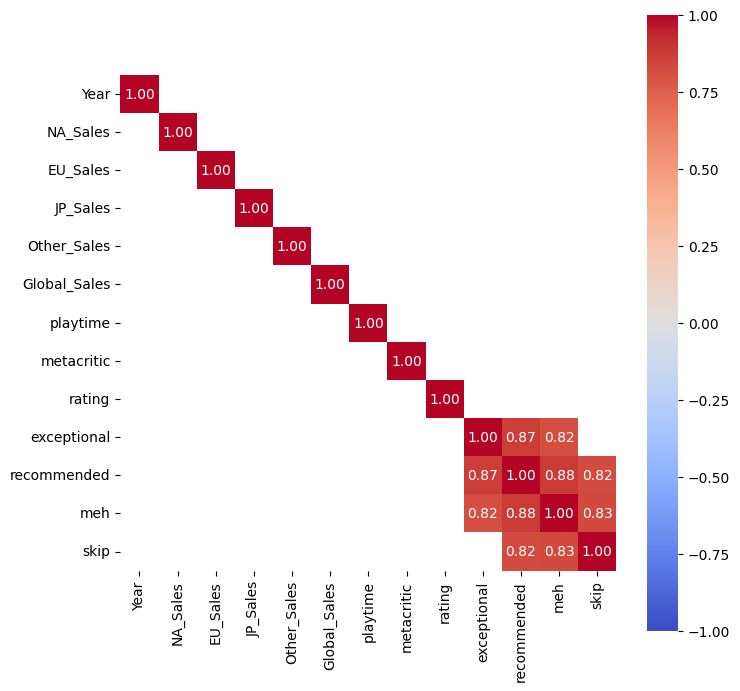

In [172]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(high_corr,
            vmin=-1,
            vmax=1,
            cbar=True,
            square=True,
            annot=True,
            fmt=".2f",
            annot_kws={"size": 10},
            cmap="coolwarm",
            ax=ax)

<Axes: >

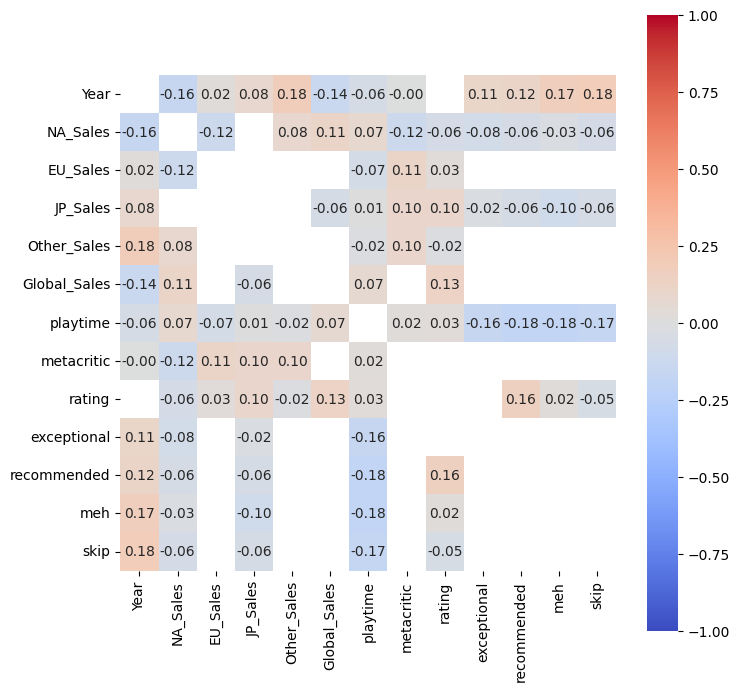

In [173]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(low_corr,
            vmin=-1,
            vmax=1,
            cbar=True,
            square=True,
            annot=True,
            fmt=".2f",
            annot_kws={"size": 10},
            cmap="coolwarm",
            ax=ax)

De lo anterior es posible concluir que:

- Las variables *Year*, *playtime*, y *rating* tienen baja correlación con la variable **Global_Sales**. Por lo tanto, estas variables serán eliminadas
- Las variables *exceptional*, *recommended*, *meh* y *skip* tienen una alta correlación entre sí. Por lo tanto, existe una relación entre ellas y se realizará reducción de dimensionalidad entre esas variables utilizando el método PCA (Principal Component Analysis).

In [174]:
df = df.drop(columns=["Year", "playtime", "rating"])

#### Reducción de dimensionalidad (Método PCA)

Del punto anterior se observó que las variables *exceptional*, *recommended*, *meh* y *skip* tienen una alta correlación entre sí. Esto sugiere que existe multicolinealidad entre dichas variables. Por lo tanto, se utilizará el método PCA para detectar el parámetro principal que las define.

In [175]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Se identifican las variables a transformar y se realiza el escalado de los datos para ejecutar PCA ya que este método es sensible a la escala de los datos.

In [176]:
# Se define la variable X como las columnas a transformar
X = df[["exceptional", "recommended", "meh", "skip"]].copy(deep=True)

# PCA es sensitivo a la escala por lo que se debe estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.1794679 , -0.1247317 , -0.22464465, -0.13063886],
       [-0.08529308,  0.29273882,  0.50670034, -0.0777902 ],
       [ 1.20456811,  0.38954358,  0.16653988,  0.23930172],
       ...,
       [-0.20749046, -0.31834122, -0.32669278, -0.34203347],
       [-0.19391297, -0.24573765, -0.25866069, -0.18348751],
       [-0.18033548, -0.28203943, -0.15661256, -0.23633616]])

Se ejecuta el método PCA.

In [177]:
pca = PCA(n_components=None) # se mantienen todos los componentes
X_pca = pca.fit_transform(X_scaled)

Se evalúa la varianza explicada por las variables.

In [178]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.80115526, 0.15202959, 0.03677173, 0.01004343])

Se mantienen las variables que explican una varianza acumulada de un **95%**. Se detecta que las dos primeras variables del PCA son capaces de explicar el 95% de la varianza.

In [179]:
# Varianza acumulada
cumulative_variance = np.cumsum(explained_variance)
print("Varianza acumulada explicada:", cumulative_variance)

Varianza acumulada explicada: [0.80115526 0.95318484 0.98995657 1.        ]


In [180]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print("Numero de componentes necesarios para tener una varianza > 95%:", n_components_95)

Numero de componentes necesarios para tener una varianza > 95%: 2


Se reduce la dimensionalidad utilizando la cantidad de componentes necesarios para mantener una varianza explicada superior a un 95%.

In [181]:
pca = PCA(n_components=n_components_95)
X_reduced = pca.fit_transform(X_scaled)

In [182]:
X_reduced

array([[-0.17156368,  0.27060118],
       [ 0.34125905, -0.20658147],
       [ 0.93800657,  0.84519296],
       ...,
       [-0.60318087,  0.06291854],
       [-0.44244426, -0.00768384],
       [-0.43004969, -0.0261328 ]])

Se agregan los componentes al Dataframe original y se eliminan las variables originales.

In [183]:
df = df.drop(columns=["exceptional", "recommended", "meh", "skip"])

In [184]:
df_pca = pd.DataFrame(X_reduced, columns=[f"PC{i+1}" for i in range(n_components_95)])
df = pd.concat([df, df_pca], axis=1)

In [187]:
print("Contribución de componentes:\n",pca.components_)

Contribución de componentes:
 [[ 0.43361121  0.53192553  0.51761873  0.51098669]
 [ 0.78736323  0.16861993 -0.43452675 -0.40350089]]


Se vuelve a evaluar la matriz de correlacion.

In [189]:
df_numeric = df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales",
                "metacritic", "PC1", "PC2"]]
spearman_corr = df_numeric.corr(method="spearman")

<Axes: >

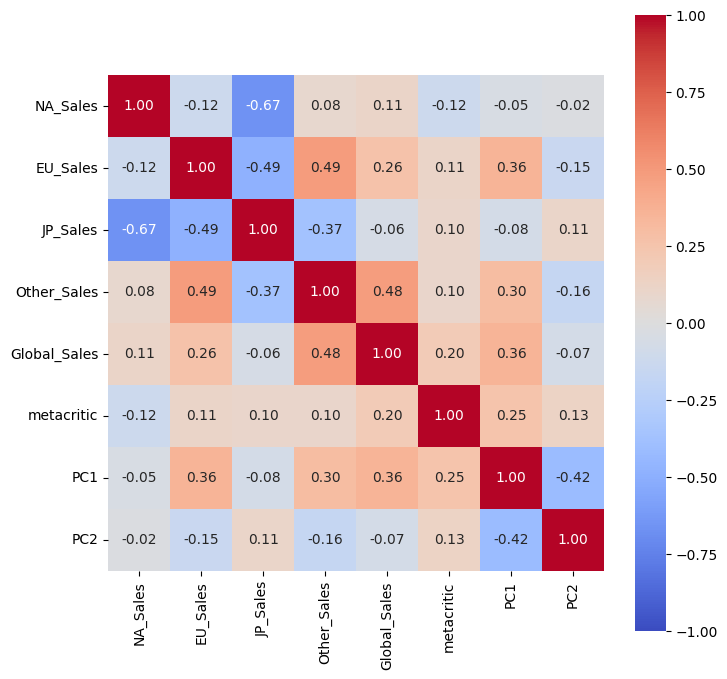

In [190]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(spearman_corr,
            vmin=-1,
            vmax=1,
            cbar=True,
            square=True,
            annot=True,
            fmt=".2f",
            annot_kws={"size": 10},
            cmap="coolwarm",
            ax=ax)

Finalmente, puede observarse que la variable PC2 tiene una baja correlación con **Global_Sales**, por lo tanto, se eliminará del dataset.

In [191]:
df = df.drop(columns=["PC2"])

## Guardado del dataset posterior a la selección de características.

Se almacena el dataset obtenido para modelado de machine learning posterior.

In [192]:
df.to_csv("videogame_data_model.csv", index=False)